In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [47]:
def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(data.head())  # Print the first few rows to inspect the data
    print(data.index)   # Print the index to check its type and format

    # Convert timezone-aware datetime to naive datetime
    if data.index.tz is not None:
        data.index = data.index.tz_localize(None)

    # Convert datetime to date-only
    data.index = pd.to_datetime(data.index).normalize()  # Normalize to remove time part, keep only date

    # Filter data within the specified date range
    start_date = pd.to_datetime('2012-01-01')
    end_date = pd.to_datetime('2020-12-31')
    data = data[(data.index >= start_date) & (data.index <= end_date)]
    
    return data

In [48]:
# Prepare data for LSTM
def prepare_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predicting the 'Close' price
    
    return np.array(X), np.array(y), scaler


In [49]:
# Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [50]:

# Train model
def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=False
    )
    return history

In [51]:
# Make predictions
def make_predictions(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

# Evaluate model
def evaluate_model(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae

# Plot results
def plot_results(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('LSTM Model: Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [52]:
# # Main function

#     # Load data
file_path = 'NVDA_data_with_metrics.csv'  # Replace with your CSV file name
data = pd.read_csv(file_path)
    
print(data.shape)
# Select features for training
features = ['Close','P/E Ratio', 'P/B Ratio', 'Dividend Yield', 'Dividend Payout Ratio', #4
            'ROE', 'ROA', 'Beta', 'Market Capitalization', 'Revenue Growth', #5
            'Debt-to-Equity Ratio', 'Free Cash Flow', 'Current Ratio', 'Quick Ratio', #4
            'PEG Ratio', 'Standard Deviation', 'Value at Risk (VaR)', 'Sharpe Ratio', #4
            'Sortino Ratio', 'Maximum Drawdown', 'Downside Deviation', 'Tracking Error', #4 
            'R-squared', 'Treynor Ratio', 'Information Ratio', 'Conditional Value at Risk (CVaR)', #4
            'Beta-adjusted Sharpe Ratio', 'Drawdown Duration', 'Ulcer Index', 'Jensens Alpha']#4
    
data = data[features]
    
# # Prepare data for LSTM
# X, y, scaler = prepare_data(data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    
# # Build and train model
# model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
# history = train_model(model, X_train, y_train)

# y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# # Make predictions
# y_pred = make_predictions(model, X_test, scaler)

    
# # Evaluate model
# mse, rmse, mae = evaluate_model(y_test_inv, y_pred)
# print(f"MSE: {mse:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"MAE: {mae:.4f}")
    
# # Plot results
# plot_results(y_test_inv, y_pred)


(3142, 37)


In [53]:
def prepare_data(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data['Close'][i + look_back])
    return np.array(X), np.array(y)

# Prepare your data
data['Close'] = data['Close'].shift(-1)  # Shift Close price to predict next day's price
data = data.dropna()  # Remove any rows with NaN values
X, y = prepare_data(data)

# Split the data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model
model = build_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))

/Users/tanishkyadav/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.9548e-05 - val_loss: 0.0562
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0766
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 0.0847
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0793
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014 - val_loss: 0.0783
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017 - val_loss: 0.0605
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - val_loss: 0.0502
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027 - val_loss: 0.0563
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0362
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0324
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 0.0177
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 295.4435
RMSE: 17.1885
MAE: 8.6739


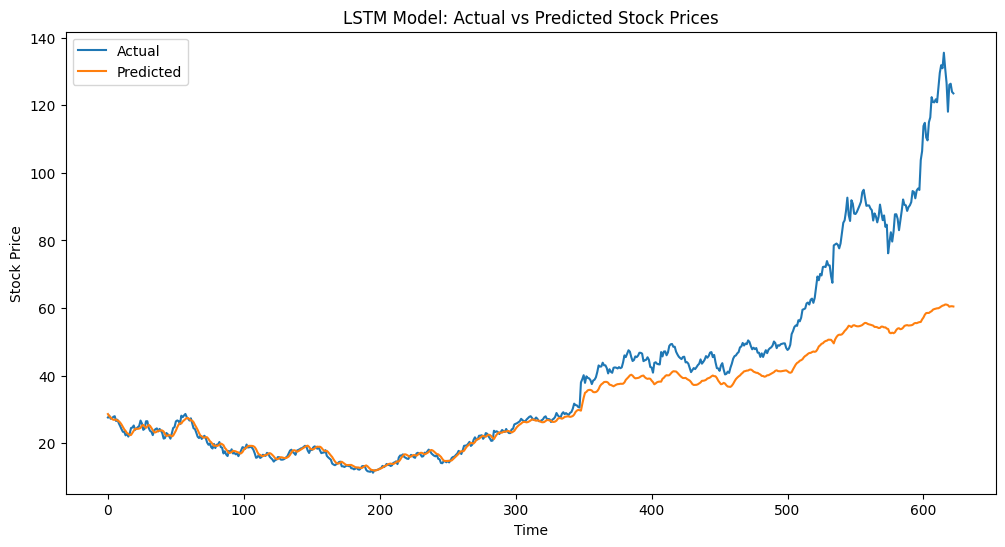

In [57]:
# Make predictions
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot((y_pred*1), label='Predicted')
plt.title('LSTM Model: Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()